## Expectation-Maximization Algorithm

The EM algorithm is an iterative method for approximating the maximum of a likelihood function.The EM algorithm comes in when we have unobserved latent variabes. A typical example is that of mixture distributions, whereby
1. we have a set of distributions,
2. each observation comes from one of these distributions with some probability, but
3. we only observe the value of each observation, and not what distribution it came from.

We'll start with a scenario where the groups should be obvious.
Suppose we flip a biased coin that comes up heads 25% \( (p=0.25) \) of the time. If it's heads, we draw from a
Normal distribution with mean 1, standard deviation 1. If it's tails, we draw from a Normal distribution with mean 7,
standard deviation 1. We repeat this process 1000 times.
Just to be clear: the latent variable here is the coin; it has an associated parameter defining whether we are
drawing from distribution 1 or 2 - ie, Bernoulli trials.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

In [140]:
np.random.seed(1)
N=1000
X=[]
for n in range(N):
    ht=np.random.binomial(n=1, p=.25)
    if ht==1:
        X.append(np.random.normal(1,1))
    else:
        X.append(np.random.normal(7,1))

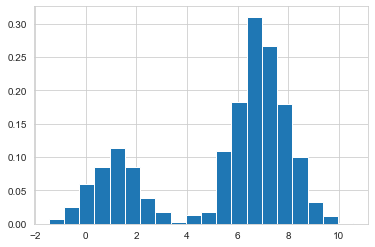

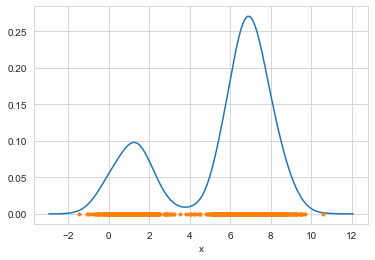

In [141]:
plt.figure(1)
plt.hist(X,bins=20,density=True);

plt.figure(2)
sns.set_style('whitegrid')
sns.kdeplot(X, bw=0.5)
plt.plot(X,np.repeat(0,len(X)),".")
plt.xlabel("x");

The separation is pretty obvious, and we expect the algorithm to perform well.
There's three separate elements:
1. The observed data,
2. The distribution parameters, (Normal distribution means)
3. The latent variables. (the 'mixture' probabilities)


The EM algorithm bounces back and forth between two processes:
1. Given the current parameters and the observed data,estimate the latent variables.
2. Given the observed data and the latent variables, estimate the parameters.

Let's start with initial values of (mu_1=0) and (mu_2=1). To make things simple, we'll assume the standard deviation is known and fixed as (sigma_1 = sigma_2 = 1). So, if we take (mu_1=0) and (mu_2=1), what is the probability, for each of the observed data, that it came from distribution 1? And distribution 2? Let's look at just the first observation for now.

In [6]:
print(X[0])
print(norm.pdf(X,0,1)[0])
print(norm.pdf(X,1,1)[0])

6.70905058840823
6.71146723369045e-11
3.3371358202532886e-08


Both values are quite small; however, it seems more likely that the first x value came from the second distribution. More specifically, given two Normal distributions with mean 0 and mean 1, it seems more likely that the first value would have come from the distribution with mean 1. Not crazy, right?.


HOWEVER! We still need to incorporate the mixing probabilities into this. We need to weigh each observation
according to the mixing probabilities, since if we believe 75% of the points should belong to distribution 2, then this should imply that a given point may be more likely to belong to distribution 2, regardless of  other information.We incorporate the information as follows:

In [7]:
pi_1 =0.5 ## our initial believed proportion from dist. 1, chosen arbitrarily
pi_2 = 0.5 ## our initial believed proportion from dist. 2, chosen arbitrarily
T_1 = pi_1 * norm.pdf(X[0],0,1)
T_2 = pi_2 * norm.pdf(X[0],1,1)
print(T_1)
print(T_2)
P_1=T_1/(T_1+T_2)
print(P_1)

3.355733616845225e-11
1.6685679101266443e-08
0.00200710937332738


So, thus far, the "probability" that our first observation came from a distribution with mean 0, vs. a distribution with mean 1, is `P_1`.

In [8]:
T_1 = pi_1 * norm.pdf(X, 0 )
T_2 = pi_2 * norm.pdf(X, 1 )
P_1=T_1/(T_1+T_2)
print(P_1[0:20])

[0.00200711 0.00509716 0.23942734 0.00208912 0.00323907 0.00519261
 0.01025963 0.00478337 0.21942442 0.00342521 0.00822662 0.00934718
 0.2079566  0.00162255 0.0041564  0.00363012 0.00101768 0.00073741
 0.0011369  0.00139472]


So, we have a set of probabilities for each item. It seems like the first few observations probably came from
distribution 2. That is, our computed 'probabilities' that these observations came from distribution 1 are very low. Now, we want to step to the second part of the EM algorithm.

**Given the observed data, as well as our estimates of the latent variables, what would we estimate the
parameters to be?**

The way we will handle this is essentially as a weighted average. Eg: for observation 1, which is `X[0]`,
`P_1[0]` of it should contribute to estimation of the mean for distribution 1, while `1-P_1[0]` of it should contribute to estimation of the mean for distribution 2.

In [9]:
P_1 = T_1 / (T_1 + T_2)
P_2 = T_2 / (T_1 + T_2)
mu_1=np.sum(X*P_1)/np.sum(P_1)
mu_2=np.sum(X*P_2)/np.sum(P_2)
print(mu_1,mu_2)
pi_1=np.mean(P_1)
pi_2=np.mean(P_2)
print(pi_1,pi_2)

0.5534991265386551 6.070333402075534
0.10220553725564369 0.8977944627443564


In [10]:
## Likelihood
l=np.prod(pi_1*norm.pdf(X,0,1)+pi_2*(norm.pdf(X,1,1)))
print("Likelihood = "+str(l))
## log-likelihood
ll=np.sum(np.log(pi_1*norm.pdf(X,0,1)+pi_2*(norm.pdf(X,1,1))))
print("Loglikelihood = "+str(ll))

Likelihood = 0.0
Loglikelihood = -15041.725119428098


mu_1= 0.98 , mu_2= 7.02 , pi_1 =0.27 , pi_2 =0.73


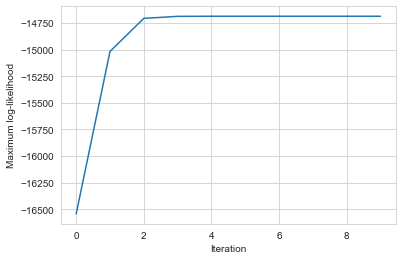

In [38]:
pi_1 =0.5 ## our initial believed proportion from dist. 1, chosen arbitrarily
pi_2 = 0.5 ## our initial believed proportion from dist. 2, chosen arbitrarily
mu_1=0
mu_2=1
Log_likelihood=[]
max_ll=-1000000
for i in range(10):
    ## Given the observed data, as well as the distribution parameters,
    ## what are the latent variables?
    T_1 = pi_1 * norm.pdf(X,mu_1,1)
    T_2 = pi_2 * norm.pdf(X,mu_2,1)
    P_1 = T_1 / (T_1 + T_2)
    P_2 = T_2 / (T_1 + T_2)
    pi_1=np.mean(P_1)
    pi_2=np.mean(P_2)
    
    ## Given the observed data, as well as the latent variables,
    ## what are the population parameters?
    mu_1=np.sum(X*P_1)/np.sum(P_1)
    mu_2=np.sum(X*P_2)/np.sum(P_2)

    ll=np.sum(np.log(pi_1*norm.pdf(X,mu_1,1)+pi_2*(norm.pdf(X,mu_1,1))))
    Log_likelihood.append(ll)
    if ll>max_ll:
        max_ll=ll
        mu_1, mu_2 = mu_1,mu_2
        pi_1, pi_2 = pi_1,pi_2
        
plt.plot(range(len(Log_likelihood)),Log_likelihood)
plt.xlabel("Iteration")
plt.ylabel("Maximum log-likelihood");
print("mu_1= "+str(np.round(mu_1,2)), ",","mu_2= "+str(np.round(mu_2,2)),
      ",","pi_1 ="+str(np.round(pi_1,2)),",","pi_2 ="+str(np.round(pi_2,2)))


Our estimates converge very quickly! And, it turns out, they are quite accurate in this case. What if the two
distributions aren't so similar? Let's have one distribution with mean 1, and the other with mean 4. We'll increase the number of iterations as well.

In [134]:
N=1000
X=[]
for n in range(N):
    ht=np.random.binomial(n=1, p=.25)
    if ht==1:
        X.append(np.random.normal(1,1))
    else:
        X.append(np.random.normal(4,1))

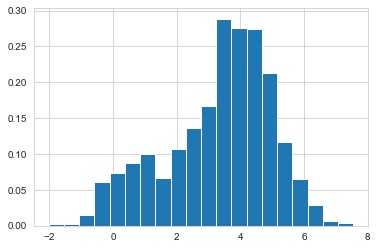

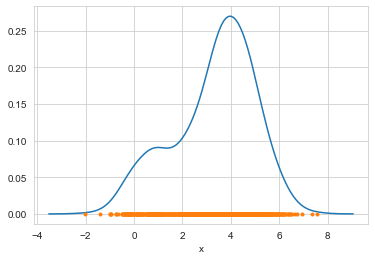

In [135]:
plt.figure(1)
plt.hist(X,bins=20,density=True);

plt.figure(2)
sns.set_style('whitegrid')
sns.kdeplot(X, bw=0.5)
plt.plot(X,np.repeat(0,len(X)),".")
plt.xlabel("x");

mu_1= 0.94 , mu_2= 4.06 , pi_1 =0.24 , pi_2 =0.76


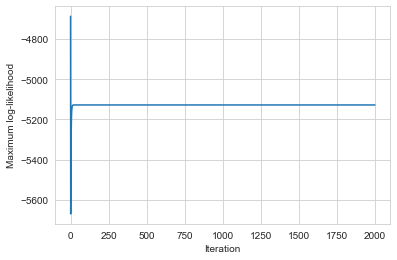

In [136]:
pi_1 =0.5 ## our initial believed proportion from dist. 1, chosen arbitrarily
pi_2 = 0.5 ## our initial believed proportion from dist. 2, chosen arbitrarily
mu_1=0
mu_2=1
Log_likelihood=[]
max_ll=-1000000
for i in range(2000):
    ## Given the observed data, as well as the distribution parameters,
    ## what are the latent variables?
    T_1 = pi_1 * norm.pdf(X,mu_1,1)
    T_2 = pi_2 * norm.pdf(X,mu_2,1)
    P_1 = T_1 / (T_1 + T_2)
    P_2 = T_2 / (T_1 + T_2)
    pi_1=np.mean(P_1)
    pi_2=np.mean(P_2)
    
    ## Given the observed data, as well as the latent variables,
    ## what are the population parameters?
    mu_1=np.sum(X*P_1)/np.sum(P_1)
    mu_2=np.sum(X*P_2)/np.sum(P_2)

    ll=np.sum(np.log(pi_1*norm.pdf(X,mu_1,1)+pi_2*(norm.pdf(X,mu_1,1))))
    Log_likelihood.append(ll)
    if ll>max_ll:
        max_ll=ll
        mu_1, mu_2 = mu_1,mu_2
        pi_1, pi_2 = pi_1,pi_2
        
plt.plot(range(len(Log_likelihood)),Log_likelihood)
plt.xlabel("Iteration")
plt.ylabel("Maximum log-likelihood");
print("mu_1= "+str(np.round(mu_1,2)), ",","mu_2= "+str(np.round(mu_2,2)),
      ",","pi_1 ="+str(np.round(pi_1,2)),",","pi_2 ="+str(np.round(pi_2,2)))


## Recap

The EM algorithm is an iterative method for estimating parameters, in the presence of latent variables, through the likelihood. It consists of two steps, which we alternate over:

1. Given the current parameters and the observed data,estimate the latent variables.
2. Given the observed data an d the latent variables, estimate the parameters.

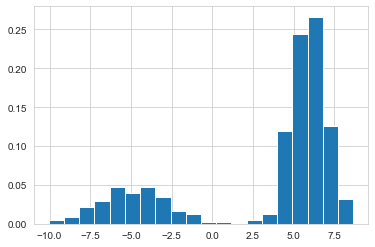

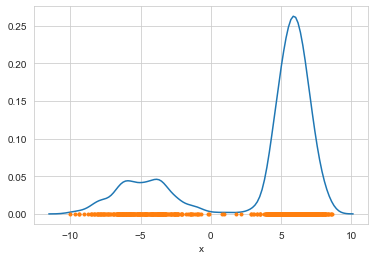

In [152]:
N=1000
X=[]
for n in range(N):
    ht=np.random.binomial(n=1, p=.25)
    if ht==1:
        X.append(np.random.normal(-5,2))
    else:
        X.append(np.random.normal(6,1))
        
plt.figure(1)
plt.hist(X,bins=20,density=True);

plt.figure(2)
sns.set_style('whitegrid')
sns.kdeplot(X, bw=0.5)
plt.plot(X,np.repeat(0,len(X)),".")
plt.xlabel("x");

mu_1= -3.42 , mu_2= 5.93 , pi_1 =0.29 , pi_2 =0.71 , sigma_1 =17.09 , sigma_2 =0.9


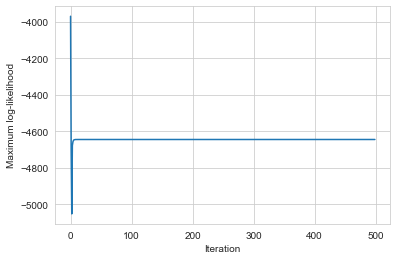

In [175]:
pi_1 =0.5 ## our initial believed proportion from dist. 1, chosen arbitrarily
pi_2 = 0.5 ## our initial believed proportion from dist. 2, chosen arbitrarily
mu_1=-2
mu_2=1
sigma_1=2
sigma_2=1
Log_likelihood=[]
max_ll=-1000000
for i in range(500):
    ## Given the observed data, as well as the distribution parameters,
    ## what are the latent variables?
    T_1 = pi_1 * norm.pdf(X,mu_1,sigma_1)
    T_2 = pi_2 * norm.pdf(X,mu_2,sigma_2)
    P_1 = T_1 / (T_1 + T_2)
    P_2 = T_2 / (T_1 + T_2)
    pi_1=np.mean(P_1)
    pi_2=np.mean(P_2)
    
    ## Given the observed data, as well as the latent variables,
    ## what are the population parameters?
    mu_1=np.mean(X*P_1)/np.sum(P_1)*len(X)
    mu_2=np.mean(X*P_2)/np.sum(P_2)*len(X)
    sigma_1= np.sum((X-mu_1)*P_1*(X-mu_1))/(pi_1*len(X))
    sigma_2= np.sum((X-mu_2)*P_2*(X-mu_2))/(pi_2*len(X))

    ll=np.sum(np.log(pi_1*norm.pdf(X,mu_1,sigma_1)+pi_2*(norm.pdf(X,mu_1,sigma_2))))
    Log_likelihood.append(ll)
    if ll>max_ll:
        max_ll=ll
        mu_1, mu_2 = mu_1,mu_2
        pi_1, pi_2 = pi_1,pi_2
        
plt.plot(range(len(Log_likelihood)),Log_likelihood)
plt.xlabel("Iteration")
plt.ylabel("Maximum log-likelihood");
print("mu_1= "+str(np.round(mu_1,2)), ",","mu_2= "+str(np.round(mu_2,2)),
      ",","pi_1 ="+str(np.round(pi_1,2)),",","pi_2 ="+str(np.round(pi_2,2)),
     ",", "sigma_1 ="+str(np.round(sigma_1,2)), ",", "sigma_2 ="+str(np.round(sigma_2,2)))


In [170]:
np.dot(P_1*(X-mu_1).T,(X-mu_1))/(pi_1*len(X))

23.456022377953452